In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('cleaned_turbo_az.csv')

In [3]:
features = ['price_azn', 'year', 'mileage', 'engine', 'horse_power', 'n_views']
X = df[features]

# Scale features (mean=0, std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

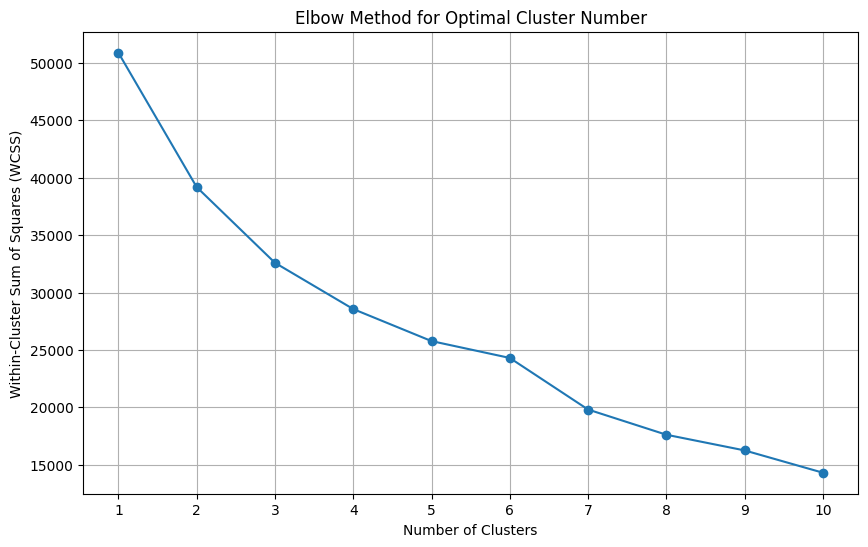

In [4]:
# Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Cluster Number')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range(1, 11))
plt.grid()
plt.show()

In [5]:
# Apply K-Means with selected clusters
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Add scaled features to dataframe for analysis
for i, feature in enumerate(features):
    df[f'scaled_{feature}'] = X_scaled[:, i]

Cluster Characteristics:
             price_azn         year        mileage    engine  horse_power  \
cluster                                                                     
0         13094.979381  2004.020275  267081.347423  1.959416   127.291409   
1         35940.680048  2018.182557   93490.478614  1.856487   183.135006   
2        161591.293403  2021.954861   25380.112847  2.375000   433.204861   
3         43877.632552  2010.286067  223098.434032  4.502219   330.981504   

             n_views  
cluster               
0        1635.332646  
1        4620.055197  
2        6052.979167  
3        3185.167694  


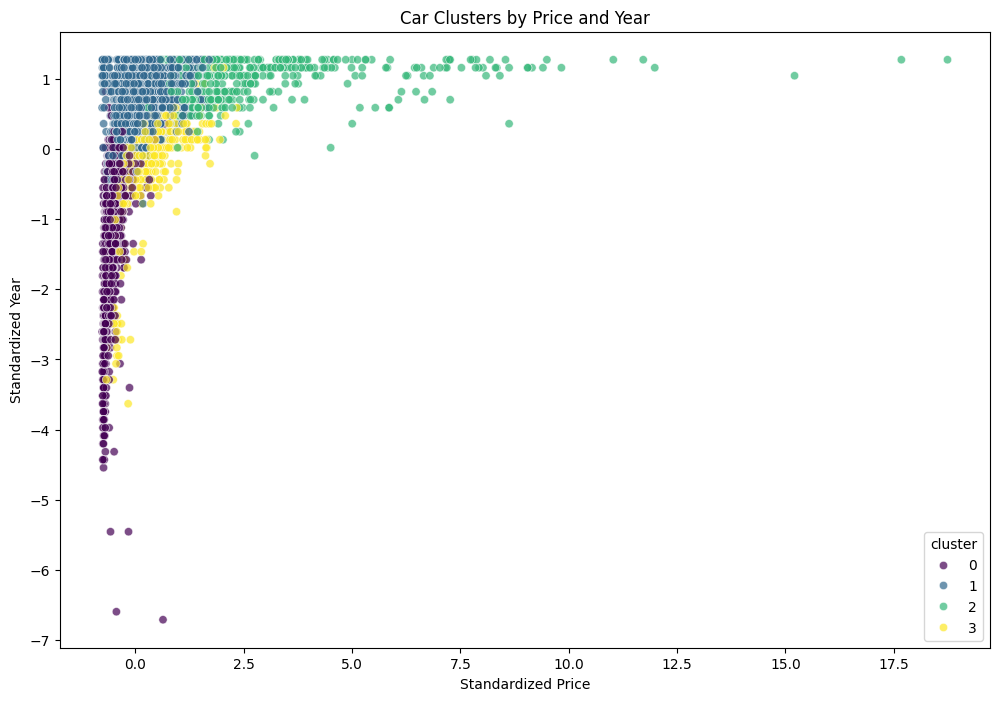

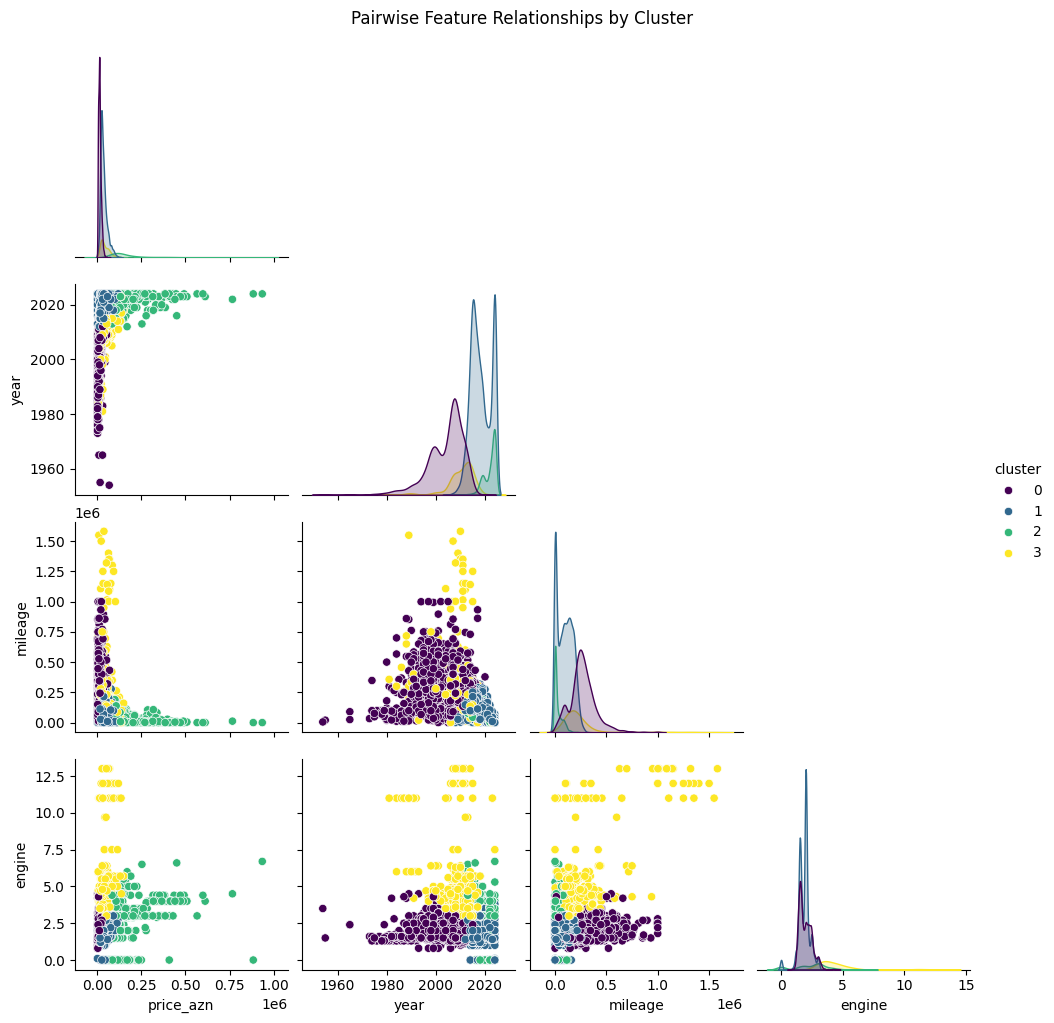

In [6]:
# Cluster statistics
cluster_stats = df.groupby('cluster')[features].mean()
print("Cluster Characteristics:")
print(cluster_stats)

# Visualize clusters (2D example)
plt.figure(figsize=(12, 8))
sns.scatterplot(x='scaled_price_azn', y='scaled_year', 
                hue='cluster', palette='viridis', 
                data=df, alpha=0.7)
plt.title('Car Clusters by Price and Year')
plt.xlabel('Standardized Price')
plt.ylabel('Standardized Year')
plt.show()

# Pairplot for multiple dimensions
sns.pairplot(df, vars=features[:4], hue='cluster', 
             palette='viridis', corner=True)
plt.suptitle('Pairwise Feature Relationships by Cluster', y=1.02)
plt.show()

In [7]:
# Calculate mean values for each cluster
cluster_profiles = df.groupby('cluster')[features].mean()

# Calculate size of each cluster
cluster_profiles['count'] = df['cluster'].value_counts().sort_index()

# Calculate z-scores to show how clusters differ from overall mean
for feature in features:
    overall_mean = df[feature].mean()
    overall_std = df[feature].std()
    cluster_profiles[f'{feature}_zscore'] = (
        (cluster_profiles[feature] - overall_mean) / overall_std
    )

print("Detailed Cluster Profiles:")
print(cluster_profiles)

Detailed Cluster Profiles:
             price_azn         year        mileage    engine  horse_power  \
cluster                                                                     
0         13094.979381  2004.020275  267081.347423  1.959416   127.291409   
1         35940.680048  2018.182557   93490.478614  1.856487   183.135006   
2        161591.293403  2021.954861   25380.112847  2.375000   433.204861   
3         43877.632552  2010.286067  223098.434032  4.502219   330.981504   

             n_views  count  price_azn_zscore  year_zscore  mileage_zscore  \
cluster                                                                      
0        1635.332646   2910         -0.507312    -1.004442        0.758174   
1        4620.055197   4185         -0.030351     0.611203       -0.480315   
2        6052.979167    576          2.592923     1.041551       -0.966250   
3        3185.167694    811          0.135353    -0.289635        0.444377   

         engine_zscore  horse_power_zscor

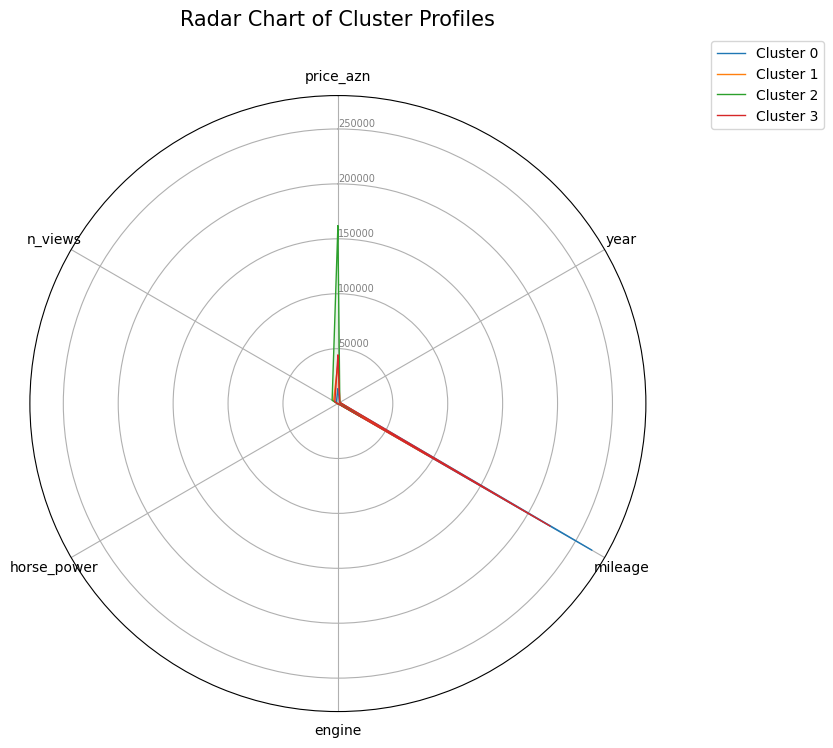

In [8]:
from math import pi

# Prepare data for radar chart
categories = features
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

for cluster in range(optimal_clusters):
    values = cluster_profiles.loc[cluster, features].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', 
            label=f'Cluster {cluster}')
    ax.fill(angles, values, alpha=0.1)

plt.xticks(angles[:-1], categories)
plt.yticks(color="grey", size=7)
ax.set_rlabel_position(0)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.title("Radar Chart of Cluster Profiles", size=15, y=1.1)
plt.show()